In [1]:
import pandas as pd

# Load the CSV file
file_path = r"TCGA Breast.csv"
data = pd.read_csv(file_path, index_col=0)

# Transpose the data
transposed_data = data.T

# Create a new column for classification
def classify_sample(sample_name):
    # Extract the last two digits of the sample name (after the last '-')
    suffix = sample_name.split('-')[-1]
    if int(suffix) < 11:  # Cancer
        return "cancer"
    elif int(suffix) > 10:  # Normal
        return "normal"
    else:
        return "unknown"  # Optional: Handle other cases

transposed_data['Classification'] = transposed_data.index.map(classify_sample)

# Check counts for each classification
classification_counts = transposed_data['Classification'].value_counts()
print("Classification counts:")
print(classification_counts)

# Check for NaN data
nan_counts = transposed_data.isna().sum().sum()
if nan_counts > 0:
    print(f"There are {nan_counts} missing values in the data.")
else:
    print("No missing values found.")


Classification counts:
Classification
cancer    1104
normal     114
Name: count, dtype: int64
No missing values found.


In [2]:
gene_filter = pd.read_csv(r"Step1_Australia.csv")
gene_symbols_to_filter = gene_filter['Gene.symbol'].unique()
filtered_transposed_data = transposed_data.iloc[:, [0]]  # Keep the first column (index 0)

# Select and filter the columns starting from the second column until the last one (index -1)
filtered_transposed_data = filtered_transposed_data.join(
    transposed_data.iloc[:, 1:-1].loc[:, transposed_data.columns[1:-1].isin(gene_symbols_to_filter)]
)

# Add the last column back (no filtering)
filtered_transposed_data[transposed_data.columns[-1]] = transposed_data.iloc[:, -1]

transposed_data = filtered_transposed_data

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Assume transposed_data is already created and includes a 'Classification' column
# Map string labels to integers ('cancer' -> 1, 'normal' -> 0)
transposed_data['Classification'] = transposed_data['Classification'].map({'cancer': 1, 'normal': 0})

# Drop rows with unknown or NaN classification
transposed_data = transposed_data.dropna(subset=['Classification'])

# Split features (X) and labels (y)
X = transposed_data.drop(columns=['Classification'])
y = transposed_data['Classification'].astype(int)

# Check for missing values in features and fill with median
X = X.dropna()

# Normalize features while retaining column names
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)




c:\Users\28640\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training Logistic Regression...
Computing SHAP values for Logistic Regression...
Generating SHAP summary plot for Logistic Regression...


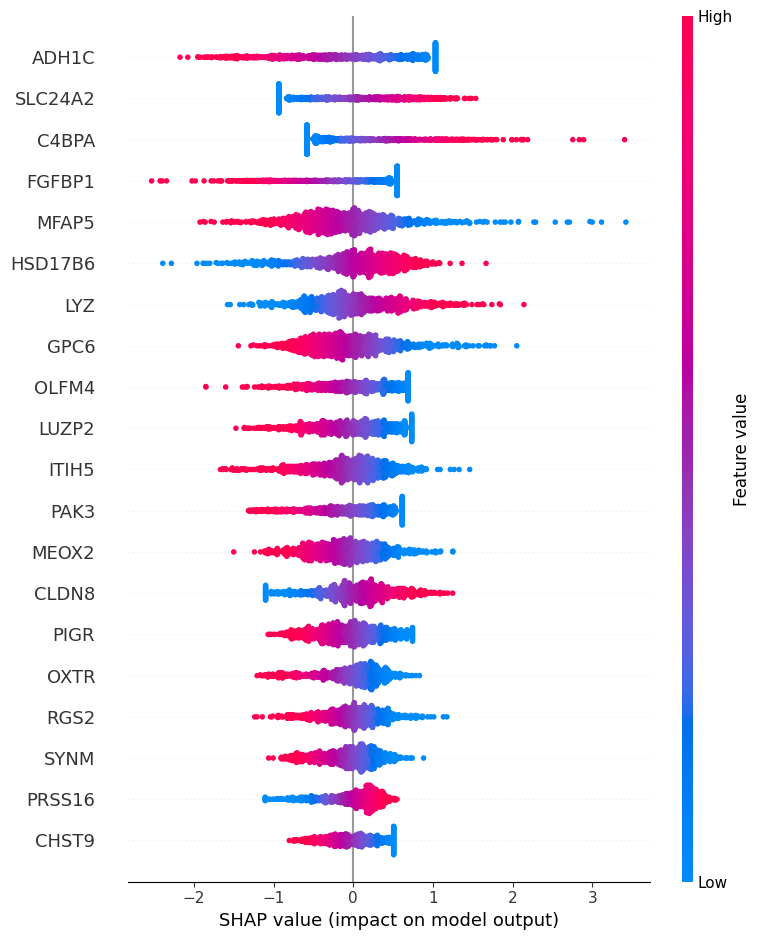

In [4]:
from sklearn.linear_model import LogisticRegression
import shap
import matplotlib.pyplot as plt

# Train Logistic Regression Model
print("Training Logistic Regression...")
logistic_model = LogisticRegression(random_state=42, max_iter=10000)
logistic_model.fit(X_train, y_train)

# Compute SHAP Values
print("Computing SHAP values for Logistic Regression...")
logistic_explainer = shap.Explainer(logistic_model, X_train)
logistic_shap_values = logistic_explainer(X_train)

# Generate SHAP Summary Plot
print("Generating SHAP summary plot for Logistic Regression...")
shap.summary_plot(logistic_shap_values, X_train, plot_type="dot")  # Use "dot" for the scatter plot format



Training XGBoost...


c:\Users\28640\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:48:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Computing SHAP values for XGBoost...
Shape of SHAP values (samples × features): (974, 329)
Shape of X_train (samples × features): (974, 329)
Generating SHAP summary plot for XGBoost...


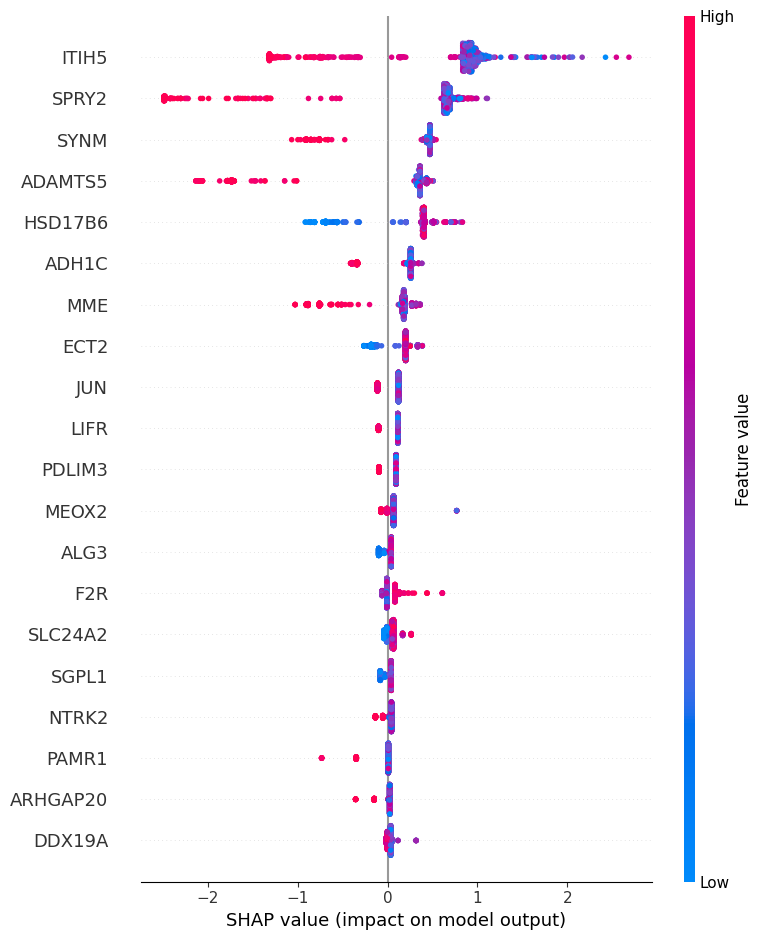

In [5]:
from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt

# Train the XGBoost Model
print("Training XGBoost...")
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train, y_train)

# Compute SHAP Values using TreeExplainer
print("Computing SHAP values for XGBoost...")
xgb_explainer = shap.TreeExplainer(xgb_model)  # Use TreeExplainer for XGBoost
xgb_shap_values = xgb_explainer(X_train)  # Unified SHAP computation

# Debugging shapes
print("Shape of SHAP values (samples × features):", xgb_shap_values.values.shape)
print("Shape of X_train (samples × features):", X_train.shape)

# Generate SHAP Summary Plot
print("Generating SHAP summary plot for XGBoost...")
shap.summary_plot(xgb_shap_values, X_train, plot_type="dot")  # "dot" for scatter plot



In [6]:
n = 50  # Define top n genes to select
logistic_coefficients = logistic_model.coef_[0]  # Extract coefficients
logistic_gene_importance = pd.DataFrame({
    'Gene': X.columns,
    'Importance': np.abs(logistic_coefficients)  # Use absolute value of coefficients
})

# Sort by importance and get top n
logistic_top_genes = logistic_gene_importance.sort_values(by='Importance', ascending=False).head(n)['Gene'].tolist()
xgb_feature_importances = pd.DataFrame({
    'Gene': X.columns,
    'Importance': xgb_model.feature_importances_
})

# Sort by importance and get top n
xgb_top_genes = xgb_feature_importances.sort_values(by='Importance', ascending=False).head(n)['Gene'].tolist()

# Combine top genes from both models and remove duplicates
combined_top_genes = list(set(logistic_top_genes + xgb_top_genes))

# Save the combined top genes as a CSV file
top_genes_df = pd.DataFrame(combined_top_genes, columns=['Top_Genes'])
top_genes_df.to_csv('Step2_USA.csv', index=False)

print("Top genes saved to Step2_USA.csv.")

Top genes saved to Step2_USA.csv.


Performing KEGG Pathway Enrichment...


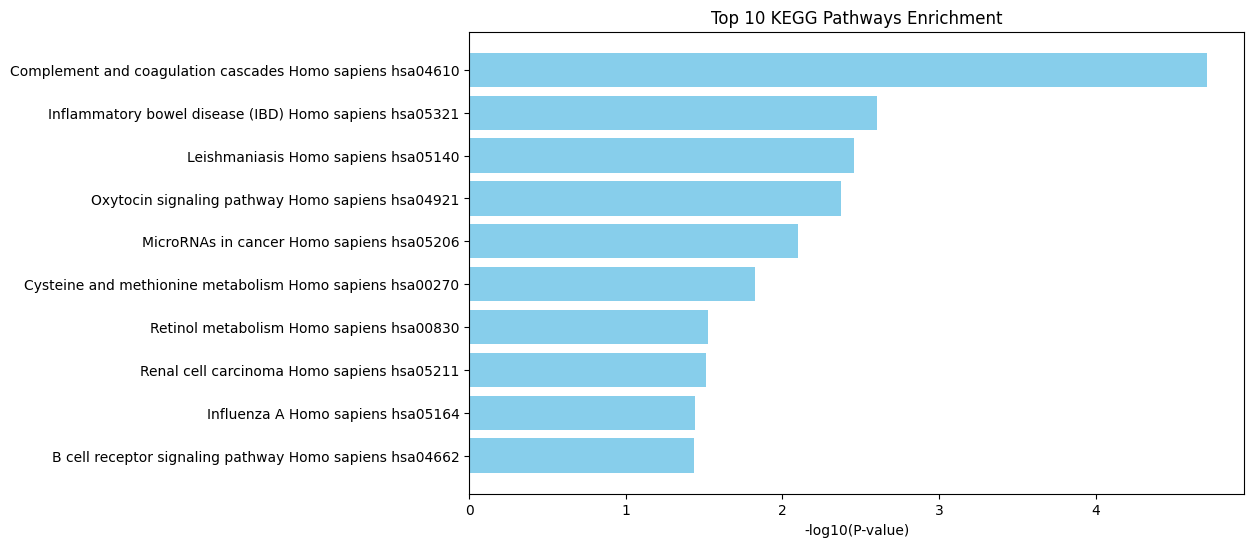

Filtered Genes Based on KEGG Pathways:
['STAT1', 'PLAU', 'PIK3AP1', 'ADH1C', 'PAK3', 'C4BPA', 'OXTR', 'RGS2', 'F2R', 'IL18', 'ABCB1', 'JUN', 'CDC25A', 'PTGS2', 'SRM', 'PLAUR', 'HSD17B6', 'BCAT1', 'ITGAX', 'SPRY2']


In [7]:
import gseapy as gp
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have a list of genes you are analyzing
#combined_top_genes = ['gene1', 'gene2', 'gene3', 'gene4', 'gene5', 'gene6', 'gene7', 'gene8', 'gene9', 'gene10', ...]  # Your list of 100 genes

# Step 1: KEGG Pathway Enrichment
print("Performing KEGG Pathway Enrichment...")
kegg_enrich = gp.enrichr(
    gene_list=combined_top_genes,
    gene_sets='KEGG_2016',  # You can choose a different KEGG version
    organism='Human',  # 'Human' or another organism as per your data
    cutoff=0.01  # Adjust the cutoff for significance (you can try 0.05 or 0.1 for more pathways)
)

# Step 2: Save the KEGG Results
kegg_results = kegg_enrich.results
kegg_results.to_csv("KEGG_Enrichment_Results.csv", index=False)

# Step 3: Plot KEGG Pathways using Bar Chart
# Plot top 10 enriched KEGG pathways based on p-value (negative log scale)
top_kegg = kegg_results.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_kegg['Term'], -np.log10(top_kegg['P-value']), color='skyblue')
plt.xlabel('-log10(P-value)')
plt.title('Top 10 KEGG Pathways Enrichment')
plt.gca().invert_yaxis()  # Reverse the y-axis to show the most significant pathways at the top
plt.show()

# Step 4: Filter Genes Based on Significant KEGG Pathways
# Extract the genes associated with the significant KEGG pathways
# Assuming `kegg_enrich.results` contains a 'Genes' column that lists associated genes

significant_genes = set()
for _, row in top_kegg.iterrows():
    genes_in_pathway = row['Genes'].split(';')  # KEGG enrichment stores genes as a semicolon-separated string
    significant_genes.update(genes_in_pathway)

# Filter the original gene list based on the genes present in the significant KEGG pathways
filtered_genes = [gene for gene in combined_top_genes if gene in significant_genes]

# Step 5: Save the Filtered Genes
filtered_genes_df = pd.DataFrame(filtered_genes)
filtered_genes_df.to_csv("Filtered_Genes_KEGG_Australia.csv", index=False, header=False)

# Optionally, print the filtered genes
print("Filtered Genes Based on KEGG Pathways:")
print(filtered_genes)

